<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

#  Taxi Demand Forecasting

We have historical data on taxi orders at airports. To attract a sufficient number of drivers during peak load periods, it is necessary to forecast the number of taxi orders for the next hour.  

**Data Description:**
`num_orders` - number of orders

## Preparation

Importing Packages

In [18]:
import os
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

Preliminary Data Analysis

In [19]:
BASE_DIR = os.getcwd()
df = pd.read_csv(f'{BASE_DIR}/datasets/taxi.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [21]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Checking for Duplicates

In [22]:
df['datetime'].duplicated().sum()

0

Changing the Data Type to datetime

In [23]:
df['datetime'] = pd.to_datetime(df['datetime'])

Setting datetime as the Index

In [24]:
df = df.set_index(df['datetime'])
df = df.drop('datetime', axis=1)

Checking if Index Values Are Sequential

In [25]:
print(df.index.is_monotonic_increasing)

True


Resampling to One Hour, Using Mean as the Aggregating Function

In [26]:
df = df.resample('1h').sum()

Simplifying the Data

In [27]:
df['num_orders'] = pd.to_numeric(df['num_orders'], downcast='integer')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 43.1 KB


In [29]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


The data has been modified as follows:  
The datetime column data type has been changed  
Dates have been set as the indexes  
Duplicates have been checked and dates have been sorted  
The data has been resampled to one hour  
The data type of the `num_orders` column has been changed to a lighter type  

## Analysis

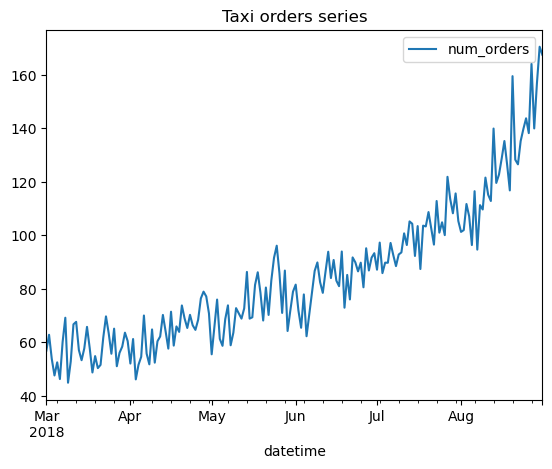

In [30]:
df.resample('1D').mean().plot(kind='line', title='Taxi orders series');

The data clearly shows a certain trend, let's try to decompose the series using seasonal decomposition

Extracting the Trend

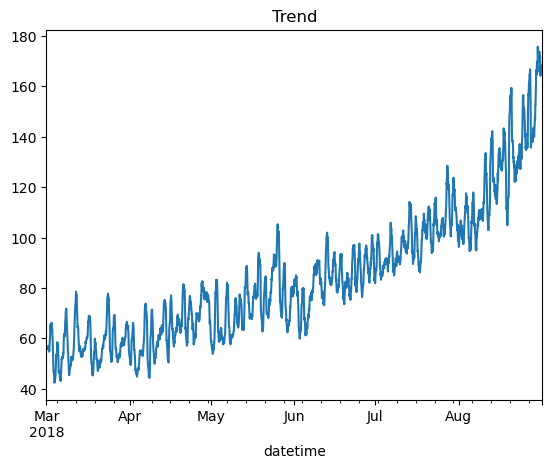

In [31]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(kind='line', title='Trend');

Extracting the Seasonality

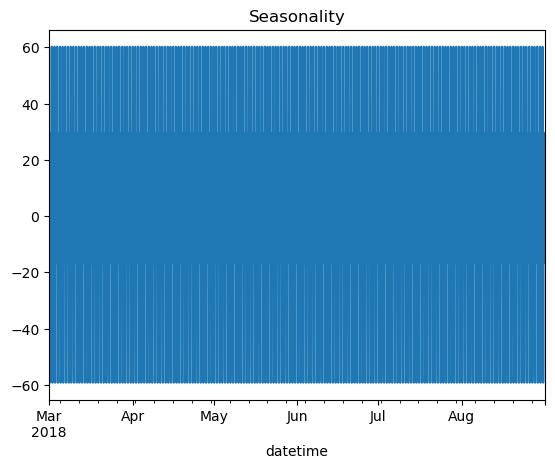

In [32]:
decomposed.seasonal.plot(kind='line', title='Seasonality');

On the current scale, it is difficult to assess seasonality. Let's take a closer look on a smaller scale, but first let's evaluate the residual

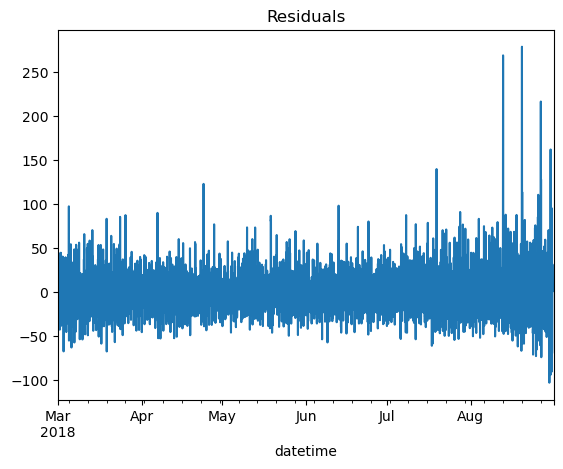

In [33]:
decomposed.resid.plot(kind='line', title='Residuals');

Examining the Seasonality on a Smaller Time Frame

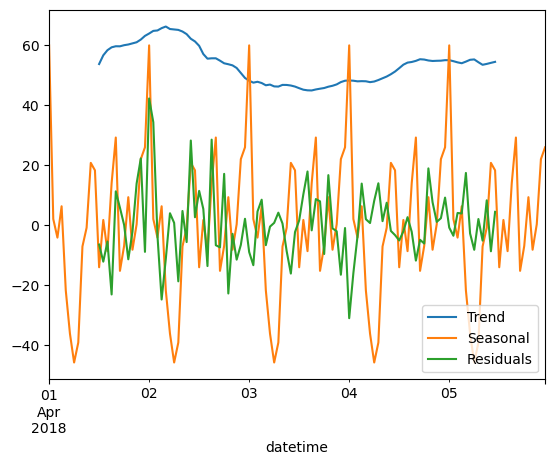

In [34]:
decomposed = seasonal_decompose(df['2018-04-01':'2018-04-5'])
decomposed.trend.plot(label='Trend')
decomposed.seasonal.plot(label='Seasonal')
decomposed.resid.plot(label='Residuals')

plt.legend()
plt.show();

On the graph, we can see a repeating pattern of five identical figures, which corresponds to the number of days displayed on the graph. As expected, the data exhibits a daily cycle.

Two components of the series have been identified: trend and daily seasonality.  

## Model Training

Feature Engineering

Adding new features: day of the week, day of the month, and hour

In [35]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['day_of_month'] = df.index.day

Creating a Function to Select Moving Average Parameters and Lag Values.

In [36]:
def transform(X, y, lag_n, ma_n):
    new_X = X.copy()
    new_y = y.copy()
    for i in range(1, lag_n+1):
        new_X[f'lag_{i}'] = new_X['num_orders'].shift(i)
    for i in range(1, ma_n+1):
        new_X[f'moving_average_{i}'] = new_X['num_orders'].shift().rolling(i).mean()
    new_X = new_X.drop('num_orders', axis=1)
    new_X = new_X.dropna()
    new_y = y.tail(new_X.shape[0])
    return new_X, new_y

Splitting the Dataset

In [37]:
target = df['num_orders']
features = df
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

Creating a Time Series Cross-Validation Object.

In [38]:
tss = TimeSeriesSplit(n_splits=8)

### Linear Regression

In [39]:
parameters = []

for i in range(1,40):
    for j in range(1,10):
        X_train, y_train = transform(features_train, target_train, i, j)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])

        params = {}

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'RMSE' : (-grid.best_score_)**0.5,
        })

pd.DataFrame(parameters).sort_values('RMSE').head()

,lag_n,ma_n,RMSE
251,28,9,26.727315
249,28,7,26.727985
246,28,4,26.729068
247,28,5,26.729321
248,28,6,26.730370


Best parameters for LinearRegression:  
RMSE = 26.72  
lag_n = 28  
ma_n = 9  

### Decision Tree

In [40]:
parameters = []

for i in range(1,40):
    for j in range(1,10):
        X_train, y_train = transform(features_train, target_train, i, j)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', DecisionTreeRegressor())
        ])

        params = {
            'regressor__max_depth': range(1,20)
        }

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'estimator_params' : grid.best_params_,
            'RMSE' : (-grid.best_score_)**0.5,
        })

pd.DataFrame(parameters).sort_values('RMSE').head()

,lag_n,ma_n,estimator_params,RMSE
17,2,9,{'regressor__max_depth': 7},28.273001
143,16,9,{'regressor__max_depth': 7},28.288111
44,5,9,{'regressor__max_depth': 7},28.355567
151,17,8,{'regressor__max_depth': 7},28.412416
150,17,7,{'regressor__max_depth': 7},28.435687


Best parameters for DecisionTreeRegressor:   
RMSE = 28.18  
max_depth = 7  
lag_n = 17  
ma_n = 9  

### Random Forest

In [41]:
parameters = []

for i in range(34,37,1):
    for j in range(18,23,1):
        X_train, y_train = transform(features_train, target_train, i, j)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor())
        ])

        params = {
            'regressor__max_depth': range(20,25,1),
            'regressor__n_estimators': range(200,240,10),
        }

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'estimator_params' : grid.best_params_,
            'RMSE' : (-grid.best_score_)**0.5,
        })

        print(parameters[-1])

pd.DataFrame(parameters).sort_values('RMSE').head()

{'lag_n': 34, 'ma_n': 18, 'estimator_params': {'regressor__max_depth': 22, 'regressor__n_estimators': 200}, 'RMSE': 24.447928639136347}
{'lag_n': 34, 'ma_n': 19, 'estimator_params': {'regressor__max_depth': 20, 'regressor__n_estimators': 230}, 'RMSE': 24.451350522214145}
{'lag_n': 34, 'ma_n': 20, 'estimator_params': {'regressor__max_depth': 22, 'regressor__n_estimators': 210}, 'RMSE': 24.514829139113324}
{'lag_n': 34, 'ma_n': 21, 'estimator_params': {'regressor__max_depth': 21, 'regressor__n_estimators': 220}, 'RMSE': 24.494429263103626}
{'lag_n': 34, 'ma_n': 22, 'estimator_params': {'regressor__max_depth': 23, 'regressor__n_estimators': 200}, 'RMSE': 24.5086162375848}
{'lag_n': 35, 'ma_n': 18, 'estimator_params': {'regressor__max_depth': 22, 'regressor__n_estimators': 210}, 'RMSE': 24.47621446985725}
{'lag_n': 35, 'ma_n': 19, 'estimator_params': {'regressor__max_depth': 23, 'regressor__n_estimators': 210}, 'RMSE': 24.47414934901412}
{'lag_n': 35, 'ma_n': 20, 'estimator_params': {'regr

,lag_n,ma_n,estimator_params,RMSE
0,34,18,"{'regressor__max_depth': 22, 'regressor__n_est...",24.447929
1,34,19,"{'regressor__max_depth': 20, 'regressor__n_est...",24.451351
6,35,19,"{'regressor__max_depth': 23, 'regressor__n_est...",24.474149
5,35,18,"{'regressor__max_depth': 22, 'regressor__n_est...",24.476214
8,35,21,"{'regressor__max_depth': 22, 'regressor__n_est...",24.481587


Best parameters for RandomForestRegressor:   
RMSE = 24.45  
max_depth = 22  
n_estimators = 210  
lag_n = 34  
ma_n = 19  

### CatBoost

In [42]:
parameters = []

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', CatBoostRegressor(
        loss_function='RMSE', 
        random_seed=1, 
        iterations=2000,  
        verbose=250,
    ))
])

for i in [27]:
    for j in [1]:
        X_train, y_train = transform(features_train, target_train, i, j)

        params = {
            'regressor__depth': [5],
        }

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'estimator_params' : grid.best_params_,
            'RMSE' : (-grid.best_score_)**0.5,
        })

        print(parameters[-1])

pd.DataFrame(parameters).sort_values('RMSE').head()

Learning rate set to 0.02895
0:	learn: 38.1656093	total: 140ms	remaining: 4m 40s
250:	learn: 21.5765414	total: 957ms	remaining: 6.67s
500:	learn: 19.1008353	total: 1.82s	remaining: 5.44s
750:	learn: 17.1908062	total: 2.62s	remaining: 4.36s
1000:	learn: 15.7949972	total: 3.59s	remaining: 3.58s
1250:	learn: 14.6069144	total: 4.39s	remaining: 2.63s
1500:	learn: 13.6109477	total: 5.19s	remaining: 1.73s
1750:	learn: 12.7574274	total: 5.99s	remaining: 852ms
1999:	learn: 11.9749933	total: 6.81s	remaining: 0us
{'lag_n': 27, 'ma_n': 1, 'estimator_params': {'regressor__depth': 5}, 'RMSE': 23.76898100172804}


,lag_n,ma_n,estimator_params,RMSE
0,27,1,{'regressor__depth': 5},23.768981


Best result for CatBoostRegressor:  
RMSE = 23.76  
iterations = 2000  
lag_n = 27  
ma_n = 1  
depth = 5  

Four models were trained on the data: linear regression, decision tree, random forest, and gradient boosting.  
The best result, with an RMSE of 23.76, was achieved by the CatBoostRegressor model. Next, we will evaluate its performance on the test set.

## Testing

In [43]:
X_train, y_train = transform(features_train, target_train, 7, 9)
X_test, y_test = transform(features_test, target_test, 7, 9)

grid.best_estimator_.fit(X_train, y_train)
prediction = grid.best_estimator_.predict(X_test)

Learning rate set to 0.028971
0:	learn: 38.1488862	total: 3.24ms	remaining: 6.47s
250:	learn: 22.8609538	total: 661ms	remaining: 4.6s
500:	learn: 20.5709363	total: 1.3s	remaining: 3.9s
750:	learn: 18.8963359	total: 1.93s	remaining: 3.22s
1000:	learn: 17.7902013	total: 2.56s	remaining: 2.56s
1250:	learn: 16.9576719	total: 3.19s	remaining: 1.91s
1500:	learn: 16.2027459	total: 3.82s	remaining: 1.27s
1750:	learn: 15.4988804	total: 4.45s	remaining: 632ms
1999:	learn: 14.8633936	total: 5.08s	remaining: 0us


In [44]:
print(mean_squared_error(y_test, prediction)**0.5)

46.00068269902999


RMSE on the test set is 46, which meets the requirements of the task.

Performing the Dickey-Fuller Test on the Residuals

In [45]:
pred_df = pd.DataFrame(prediction).set_index(y_test.index)[0]
residuals = pred_df - y_test

In [46]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(residuals)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -21.949875633066014
p-value: 0.0
Critical Values: {'1%': -3.445578199334947, '5%': -2.8682536932290876, '10%': -2.570346162765775}


P-value is 0.0, indicating that the series is stationary.  
Let's analyze it visually.

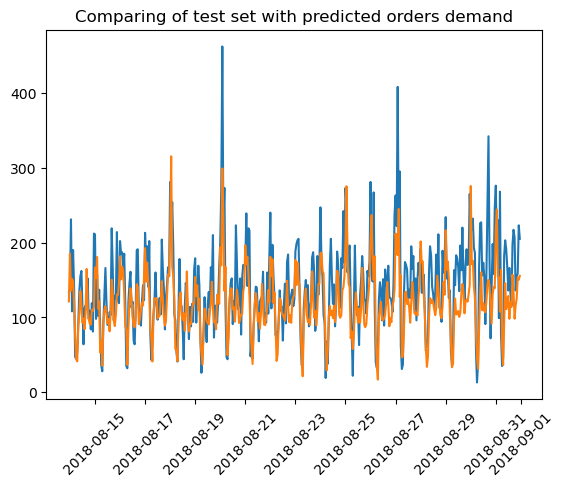

In [47]:
import matplotlib.pyplot as plt

plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, prediction, label='Predicted')
plt.xticks(rotation=45)
plt.title('Comparing of test set with predicted orders demand')
plt.show()


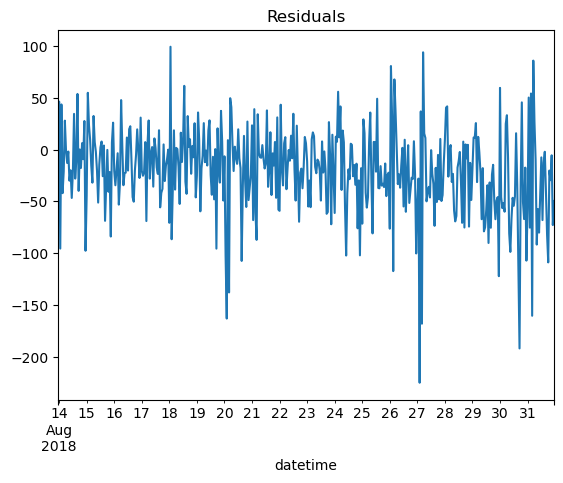

In [48]:
residuals.plot(kind='line', title='Residuals');

Visually, we cannot identify any patterns in the residuals, which indicates that the model has been trained correctly and can be recommended for further use.

## Conclusion

Four models were trained: linear regression, decision tree, random forest, and gradient boosting.  
The best result on cross-validation was achieved by the `CatBoostRegressor` model, with an RMSE of 23.76. On the test set, the RMSE is 46.  
The residuals have passed the Dickey-Fuller test for stationarity.